In [13]:
%pylab inline
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import numpy.ma as ma
from scipy.stats.stats import pearsonr, normaltest
from scipy.spatial.distance import correlation
import matplotlib.pyplot as plt 
import numpy as np

Populating the interactive namespace from numpy and matplotlib


/Users/abm7053/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['corrcoef']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [8]:
#Main goal: predict the power demand 24 hours later 
df=pd.read_csv("Toronto_power_demand.csv", parse_dates=['Date'], index_col=0)
df['temperature']=df['temperature'].shift(24*1) #shifter by one day 
print(df.tail())
#each row (after shifting) has a tempreateure and the power demand 24 hours later

#starting point: use temp to predict the power demand 24 hours later.

                  Date  Hour  power  temperature
key                                             
20201231:19 2020-12-31    19   5948          4.9
20201231:20 2020-12-31    20   5741          4.5
20201231:21 2020-12-31    21   5527          3.7
20201231:22 2020-12-31    22   5301          2.9
20201231:23 2020-12-31    23   5094          2.1


There are 35064 rows, which is 1461*24=35064, for 1461 days. And The data is already in sorted order
It is natural to think that there is a relationship between power demand and temperature.


Text(0.5, 1.0, 'Power Demand vs Temperature')

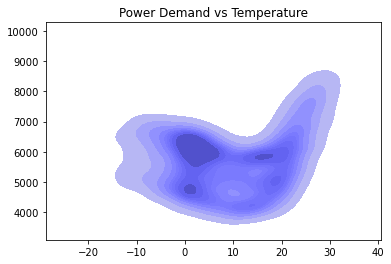

In [10]:
ndays=len(set(df['Date']))
print("There are {} rows, which is {}*24={}, for {} days. And The data is already in sorted order" .format(df.shape[0], ndays, ndays*24, ndays))
# See the relationship between temp and power
print("It is natural to think that there is a relationship between power demand and temperature.")
sns.kdeplot(df['temperature'].values, y=df['power'].values,color='blue',shade=True )
plt.title("Power Demand vs Temperature")

Clearly not a linear relationship

In [11]:
#creates two new predictors to use for a Lin. Reg. model


print("""
It is not a linear relationship. We create two features corresponding to hot and cold weather, which makes \
it possible to develop a linear model. 
""")
is_hot=(df['temperature']>15).astype(int)
print("{:f}% of data points are hot".format(is_hot.mean()*100))
df['temp_hot']=df['temperature']*is_hot
df['temp_cold']=df['temperature']*(1-is_hot)
df.tail()


It is not a linear relationship. We create two features corresponding to hot and cold weather, which makes it possible to develop a linear model. 

34.813484% of data points are hot


,Date,Hour,power,temperature,temp_hot,temp_cold
key,,,,,,
20201231:19,2020-12-31,19,5948,4.9,0.0,4.9
20201231:20,2020-12-31,20,5741,4.5,0.0,4.5
20201231:21,2020-12-31,21,5527,3.7,0.0,3.7
20201231:22,2020-12-31,22,5301,2.9,0.0,2.9
20201231:23,2020-12-31,23,5094,2.1,0.0,2.1


In [15]:
# A few helper functions

#creates a lin reg model1 
  #input is the list of predictors 
  # response is hardcoded to be power 
  # implements all steps of Lin Reg 
  # Returns the residuals as output
def build_model(features):
  X=sm.add_constant(df[features])
  y=df['power']
  model = sm.OLS(y,X, missing='drop').fit()
  predictions = model.predict(X) 
  display(model.summary()) 
  res=y-predictions
  return res 

# plots the residuals against time 
def plt_residual(res):
  plt.plot(range(len(res)), res) 
  plt.ylabel('Residual')
  plt.xlabel("Hour")

#takes the res array of all obs, takes its corr with the time 
# time-lagged version and display a kde plot
  #note that all obs ordered in time 
  # a lagged version of the array is the same array shifted
def plt_residual_lag(res, nlag):
  x=res.values
  y=res.shift(nlag).values
  sns.kdeplot(x,y=y,color='blue',shade=True )
  plt.xlabel('res')
  plt.ylabel("res-lag-{}".format(nlag))
  rho,p=corrcoef(x,y)
  plt.title("n_lag={} hours, correlation={:f}".format(nlag, rho))

#plots the autocrrelation of the residual array
#autocorrelation of an array: its correlation with all its shifted 
  #versions
#Autocorr plot: the corr vs the amount shifted (lagged)
def plt_acf(res):
  plt.rcParams['figure.figsize'] = [18, 5]
  acorr = sm.tsa.acf(res.dropna(), nlags = len(res.dropna())-1)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(acorr)
  ax1.set_ylabel('corr')
  ax1.set_xlabel('n_lag')
  ax1.set_title('Auto Correlation')
  ax2.plot(acorr[:4*7*24])
  ax2.set_ylabel('corr')
  ax2.set_xlabel('n_lag')
  ax2.set_title('Auto Correlation (4-week zoomed in) ')
  plt.show()
  pd.set_option('display.max_columns', None)
  adf=pd.DataFrame(np.round(acorr[:30*24],2).reshape([30, 24] ))
  adf.index.name='day'
  display(adf)
  plt.rcParams['figure.figsize'] = [9, 5]

#a cleaned versions of taking the corr coeff
def corrcoef(x,y):
    a,b=ma.masked_invalid(x),ma.masked_invalid(y)
    msk = (~a.mask & ~b.mask)
    return pearsonr(x[msk],y[msk])[0], normaltest(res, nan_policy='omit')[1]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  power   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     4251.
Date:                Wed, 08 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:01:23   Log-Likelihood:            -2.8766e+05
No. Observations:               35040   AIC:                         5.753e+05
Df Residuals:                   35037   BIC:                         5.753e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5501.3027      6.222    884.115      0.000    5489.107    5513.499
temp_hot      31.8488      0.462     68.911      0.000      30.943      32.755
temp_cold    -37.5088      0.827    -45.364      0.000     -39.129     -35.888
==============================================================================
Omnibus:                      945.032   Durbin-Watson:                   0.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              469.200
Skew:                           0.034   Prob(JB):                    1.30e-102
Kurtosis:                       2.437   Cond. No.                         17.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/Users/abm7053/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


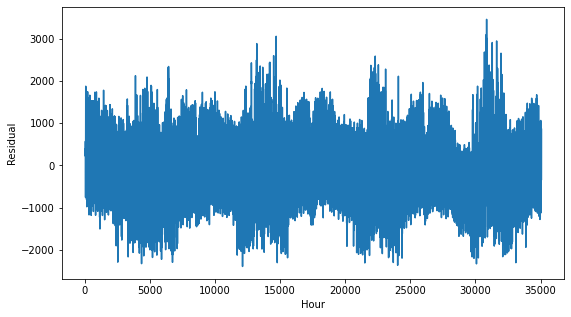

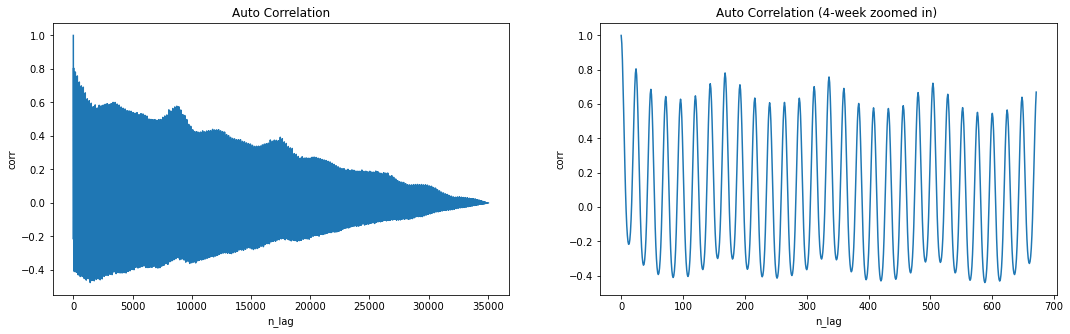

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,,,,
0,1.00,0.95,0.85,0.72,0.56,0.40,0.24,0.09,-0.02,-0.11,-0.16,-0.20,-0.22,-0.21,-0.19,-0.14,-0.07,0.03,0.15,0.30,0.45,0.58,0.70,0.78
1,0.81,0.77,0.68,0.55,0.40,0.25,0.09,-0.04,-0.15,-0.23,-0.29,-0.32,-0.34,-0.33,-0.31,-0.26,-0.19,-0.09,0.04,0.18,0.33,0.47,0.58,0.66
2,0.69,0.65,0.57,0.45,0.31,0.16,0.01,-0.12,-0.22,-0.30,-0.35,-0.38,-0.39,-0.38,-0.36,-0.31,-0.23,-0.13,-0.00,0.14,0.29,0.42,0.54,0.62
3,0.64,0.61,0.53,0.42,0.28,0.13,-0.01,-0.14,-0.24,-0.32,-0.37,-0.40,-0.41,-0.40,-0.37,-0.32,-0.25,-0.15,-0.02,0.12,0.27,0.41,0.52,0.60
4,0.63,0.60,0.52,0.41,0.27,0.12,-0.02,-0.14,-0.24,-0.32,-0.37,-0.40,-0.40,-0.39,-0.36,-0.31,-0.24,-0.13,-0.01,0.14,0.28,0.42,0.54,0.62
5,0.65,0.62,0.54,0.43,0.30,0.15,0.01,-0.11,-0.21,-0.28,-0.33,-0.36,-0.36,-0.35,-0.32,-0.27,-0.19,-0.08,0.04,0.19,0.34,0.48,0.60,0.69
6,0.72,0.69,0.61,0.50,0.36,0.21,0.07,-0.05,-0.15,-0.22,-0.27,-0.29,-0.30,-0.29,-0.26,-0.21,-0.13,-0.02,0.11,0.25,0.40,0.55,0.67,0.75
7,0.78,0.75,0.67,0.54,0.40,0.25,0.10,-0.03,-0.13,-0.21,-0.26,-0.29,-0.30,-0.30,-0.27,-0.22,-0.15,-0.05,0.07,0.21,0.36,0.49,0.61,0.69
8,0.71,0.68,0.60,0.48,0.34,0.19,0.04,-0.09,-0.19,-0.27,-0.32,-0.35,-0.36,-0.36,-0.33,-0.28,-0.21,-0.12,0.01,0.14,0.29,0.42,0.53,0.61


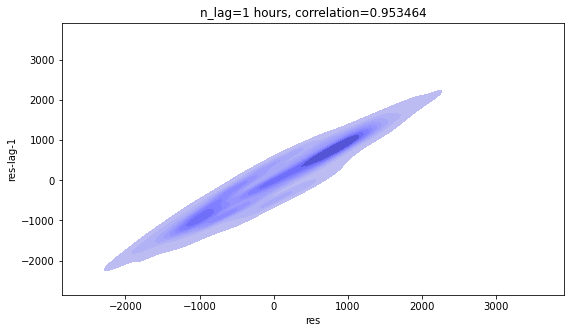

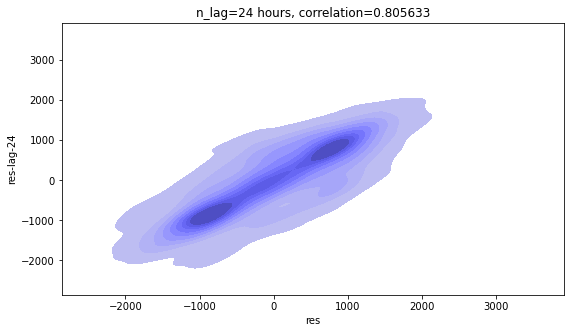

In [16]:
#First model: a model with the two temp predictors 
res=build_model(['temp_hot', 'temp_cold'])
plt_residual(res)  
plt_acf(res)
plt_residual_lag(res,1) # 1 hour - lagged version
plt.show()
plt_residual_lag(res,24) # 1 day - lagged version
plt.show()

High corr between subseq hours 
    this will stay that way 
Corr gets lower during the day 
next day same time - high corr
next week same day- high corr 
the model is uninformed of the time 
These correlations between error terms, which are caused by the model causing the same error over and over, should not happen. 
They violate the assumption of each obs being indep. 
This caused low RMSE for traning data and hihg RMSE for test data
Check R2- 0.2 clearly the model is not a getting a good fit 

How to account for this issue? 
    Make each obs more indep
    add more predictors to make the obs at the same time each day and the same day 
    each week more independent 

If your data is time-series, one common way is addig the lag terms. 
Lag term for the energy: add the energy demand 24 hours ago as another predictor
we will have three predictors, temp hot, temp cold, and energy demand 24 hours agao 

In [17]:
#shifting the power column by a day 
df['power_lag_1_day']=df['power'].shift(24)
df.tail()

,Date,Hour,power,temperature,temp_hot,temp_cold,power_lag_1_day
key,,,,,,,
20201231:19,2020-12-31,19,5948,4.9,0.0,4.9,6163.0
20201231:20,2020-12-31,20,5741,4.5,0.0,4.5,5983.0
20201231:21,2020-12-31,21,5527,3.7,0.0,3.7,5727.0
20201231:22,2020-12-31,22,5301,2.9,0.0,2.9,5428.0
20201231:23,2020-12-31,23,5094,2.1,0.0,2.1,5104.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  power   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                 4.513e+04
Date:                Wed, 08 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:11:46   Log-Likelihood:            -2.6375e+05
No. Observations:               35040   AIC:                         5.275e+05
Df Residuals:                   35036   BIC:                         5.275e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             689.2701     15.384     44.806      0.000     659.118     719.422
temp_hot            3.2158      0.250     12.853      0.000       2.725       3.706
temp_cold          -1.3464      0.433     -3.110      0.002      -2.195      -0.498
power_lag_1_day     0.8747      0.003    319.552      0.000       0.869       0.880
==============================================================================
Omnibus:                     2035.537   Durbin-Watson:                   0.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5794.290
Skew:                           0.301   Prob(JB):                         0.00
Kurtosis:                       4.899   Cond. No.                     3.69e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/Users/abm7053/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


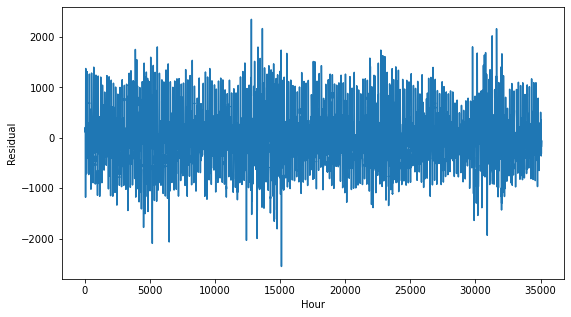

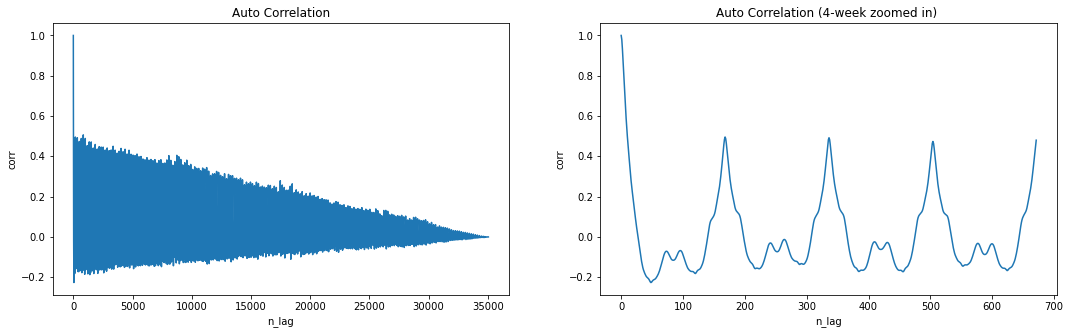

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,,,,
0,1.00,0.98,0.93,0.87,0.81,0.75,0.70,0.64,0.59,0.54,0.50,0.46,0.42,0.39,0.35,0.31,0.28,0.25,0.22,0.20,0.17,0.15,0.12,0.09
1,0.07,0.05,0.03,0.00,-0.02,-0.04,-0.06,-0.08,-0.10,-0.12,-0.14,-0.15,-0.16,-0.17,-0.18,-0.19,-0.19,-0.20,-0.20,-0.20,-0.21,-0.21,-0.22,-0.22
2,-0.23,-0.23,-0.22,-0.22,-0.21,-0.21,-0.21,-0.21,-0.21,-0.20,-0.20,-0.19,-0.18,-0.18,-0.17,-0.16,-0.15,-0.14,-0.12,-0.11,-0.10,-0.09,-0.08,-0.08
3,-0.07,-0.07,-0.07,-0.07,-0.08,-0.09,-0.09,-0.10,-0.11,-0.11,-0.11,-0.12,-0.12,-0.12,-0.11,-0.11,-0.11,-0.10,-0.09,-0.09,-0.08,-0.07,-0.07,-0.07
4,-0.07,-0.07,-0.07,-0.08,-0.09,-0.10,-0.11,-0.12,-0.13,-0.14,-0.14,-0.15,-0.16,-0.16,-0.16,-0.17,-0.17,-0.17,-0.17,-0.17,-0.17,-0.17,-0.18,-0.18
5,-0.18,-0.18,-0.17,-0.17,-0.17,-0.16,-0.16,-0.16,-0.16,-0.15,-0.14,-0.14,-0.13,-0.12,-0.10,-0.09,-0.07,-0.05,-0.04,-0.02,0.00,0.02,0.04,0.06
6,0.07,0.08,0.09,0.09,0.10,0.10,0.11,0.12,0.13,0.14,0.16,0.18,0.19,0.21,0.23,0.25,0.27,0.30,0.33,0.36,0.39,0.43,0.46,0.48
7,0.50,0.49,0.46,0.43,0.40,0.37,0.34,0.31,0.28,0.26,0.24,0.22,0.21,0.19,0.18,0.16,0.15,0.14,0.13,0.13,0.12,0.12,0.12,0.11
8,0.10,0.09,0.07,0.06,0.04,0.02,-0.00,-0.02,-0.04,-0.05,-0.07,-0.08,-0.09,-0.10,-0.11,-0.11,-0.12,-0.12,-0.13,-0.13,-0.13,-0.14,-0.15,-0.15


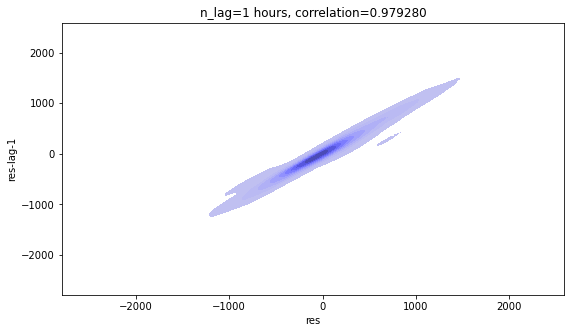

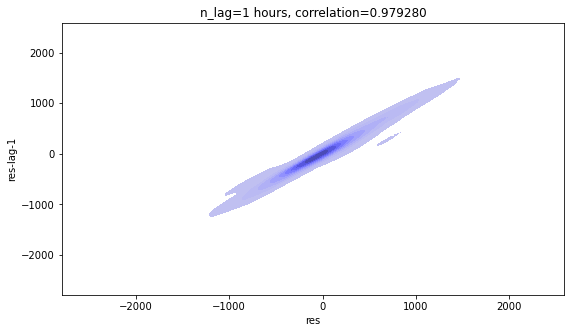

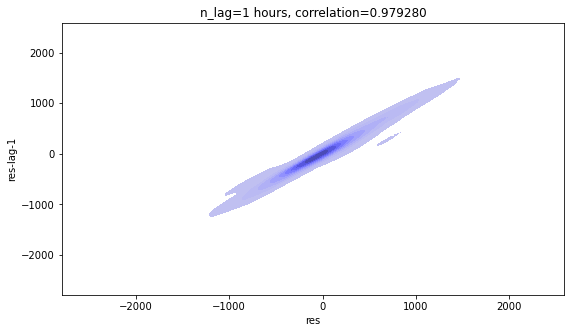

In [18]:
#build new model with the three predictors
res=build_model(['temp_hot', 'temp_cold', 'power_lag_1_day' ])
plt_residual(res)
plt_acf(res)

plt_residual_lag(res, 1) #1 hour lagged version
plt.show()
plt_residual_lag(res, 1) #1 day lagged version
plt.show()
plt_residual_lag(res, 1) #1 week lagged version
plt.show()

Adding the 1-day lag predictor got rid of the daily correlation. (same hour eachday)
We stil have the weekly correlation left (same day each week)
the model knows what time is it
Now, we will add the 1 week lag term as another pred. 

In [19]:
df['power_lag_1_week']=df['power'].shift(24*7)
print(df.tail())
#same functions and figures.

                  Date  Hour  power  temperature  temp_hot  temp_cold  \
key                                                                     
20201231:19 2020-12-31    19   5948          4.9       0.0        4.9   
20201231:20 2020-12-31    20   5741          4.5       0.0        4.5   
20201231:21 2020-12-31    21   5527          3.7       0.0        3.7   
20201231:22 2020-12-31    22   5301          2.9       0.0        2.9   
20201231:23 2020-12-31    23   5094          2.1       0.0        2.1   

             power_lag_1_day  power_lag_1_week  
key                                             
20201231:19           6163.0            5833.0  
20201231:20           5983.0            5665.0  
20201231:21           5727.0            5474.0  
20201231:22           5428.0            5273.0  
20201231:23           5104.0            5010.0  


In [ ]:
res=build_model(['temp_hot', 'temp_cold', 'power_lag_1_day','power_lag_1_week' ])
plt_residual(res)
plt_acf(res)

plt_residual_lag(res, 1) #1 hour lagged version
plt.show()
plt_residual_lag(res, 1) #1 day lagged version
plt.show()
plt_residual_lag(res, 1) #1 week lagged version
plt.show()

Weekly correlation is not gone but suppressed by adding the 1-week lagged predictor
Both 1-day and 1-week lag predictors change the R2 a lot
They suppress a lot of correlation (daily and weekly)

Adding 2-week lag predictor- R2 doesn't change that much 
Because there wasn't a biweekly correlation in the res plot 

This is one way of addressing correlation in the dataset 
    Specific to time-series 

If you know some corr exsits between some obs 
    measurements are taken from the same family, same customer base

You need to figure out some new predictors to make the obs more indep

In assignment C, you can use the same helper functions 
with some edits 

def build_model(features):
  X=sm.add_constant(df[features]) # features with dates - choose all obs up until a certain date
  y=df['power'] # filter with date
  model = sm.OLS(y,X, missing='drop').fit()
  predictions = model.predict(X) 
  display(model.summary()) 
  res=y-predictions
  return res 

predictions in the assignment for each day in 2020, using all the previous days as tranning data 
train 366 models- use a for loop 

See how the RMSE improves with each lag predictor 
    1-day 
    1-week
    2-week